# Kompresija slike korišćenjem algoritma k-sredina

Sledeći primer ilustruje korišćenje algoritma k-sredina u kompresiji slika. Ideja je redukovati broj boja koje se koriste za prikaz same slike, a time i memoriju koju ona zahteva. 

Primer je motivisan primerom sa [zvaničnog sajta biblioteke scikit-learn](https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html#sphx-glr-auto-examples-cluster-plot-color-quantization-py).

In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from time import time

Eksperiment ćemo izdvoditi nad slikom `china.jpg` koju ćemo učitatiti iz `datasets` paketa korišćenjem funkcije `load_sample_image`. 

In [3]:
image = load_sample_image("china.jpg")

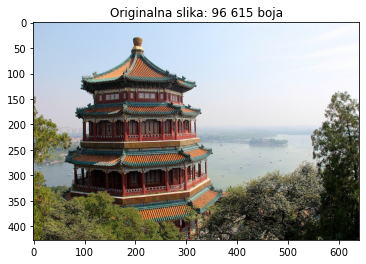

In [4]:
plt.imshow(image)
plt.title('Originalna slika: 96 615 boja')
plt.show()

Slika je dimenzija 427x640 piksela i ima 3 kanala boja (RGB).

In [5]:
image.shape

(427, 640, 3)

In [6]:
image.nbytes

819840

Za zapis jednog piksela koristi se jedan bajt - njime se može opisati 256 različitih nijansi boja.

In [7]:
image.dtype

dtype('uint8')

Parametar `n_colors` će označavati broj boja koje će biti korišćene u kompresovanoj slici, a ujedno i broj klastera koje će algoritam tražiti. Za zapis jedne ovakve boje biće potrebno  bita.

In [8]:
n_colors = 64

Pre obrade, izvrišićemo normalizaciju piskela slike i transformaciju u 2D vektor.

In [9]:
image = image.astype(np.float64) / 255

In [10]:
image_width, image_height, image_depth = image.shape

In [11]:
image_2D = np.reshape(image, (image_width*image_height, image_depth))

In [12]:
image_2D.shape

(273280, 3)

Sada ćemo iskoristiti k-means algoritam za kreiranje klastera. Model ćemo naučiti nad 10000 proizvoljno odabranih piksela slike, a potom ćemo ga iskoristiti za dalje bojenje slike.

In [13]:
kmeans_start = time()

image_2D_sample = shuffle(image_2D, random_state=0)[:10000]

kmeans = KMeans(n_clusters=n_colors, random_state=0)
kmeans.fit(image_2D_sample)
kmeans_end = time()


In [14]:
print('Algoritma se izvrsavao ukupno : ', kmeans_end-kmeans_start, ' sekunde')

Algoritma se izvrsavao ukupno :  2.2923529148101807  sekunde


In [15]:
kmeans_prediction_start = time()
image_labels = kmeans.predict(image_2D)
kmeans_prediction_end = time()

In [16]:
print('Algoritma se izvrsavao ukupno : ', kmeans_prediction_end-kmeans_prediction_start, ' sekunde')

Algoritma se izvrsavao ukupno :  0.036509037017822266  sekunde


In [17]:
image_labels.shape

(273280,)

In [18]:
image_labels[0]

12

In [19]:
kmeans.cluster_centers_.shape

(64, 3)

Centroide izdvojenih klastera ćemo zvati paletom boja (engl. codebook). Funkciju `recreate_image` ćemo koristi za kreiranje slike na osnovu prosleđene palete boja, labela piksela i dimenzija slike.  

In [20]:
def recreate_image(codebook, labels, image_width, image_height):
    
    # broj kanala slike
    depth = codebook.shape[1]
    
    # nova slika je inicijalno matrica nula dimenzije image_width x image_height x depth
    image = np.zeros((image_width, image_height, depth))
    
    # za svaku labelu piksela nove slike očitavamo boju koja joj je pridružena prilikom klasterovanja
    label_idx = 0
    for i in range(image_width):
        for j in range(image_height):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    
    # kao rezultat vraćamo kreiranu sliku
    return image


In [21]:
kmeans_image = recreate_image(kmeans.cluster_centers_, image_labels, image_width, image_height)

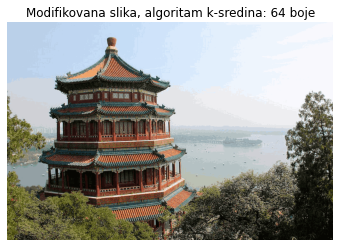

In [22]:
plt.axis('off')
plt.title('Modifikovana slika, algoritam k-sredina: 64 boje')
plt.imshow(kmeans_image)
plt.show()

Možemo da istražimo i kakva slika bi se dobila nasumičnim izborom palete boja sa 64 boje. Svakom pikselu slike bi se u ovom slučaju pridružila boja njemu najbližeg obeležja.

In [23]:
codebook_random = shuffle(image_2D, random_state=0)[:n_colors]

In [24]:
codebook_random.shape

(64, 3)

In [25]:
labels_random = pairwise_distances_argmin(codebook_random, image_2D, axis=0)

In [26]:
image_random = recreate_image(codebook_random, labels_random, image_width, image_height)

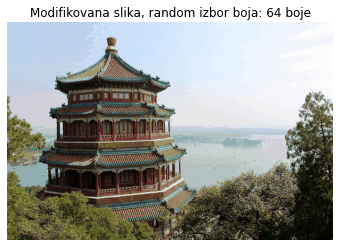

In [27]:
plt.axis('off')
plt.title('Modifikovana slika, random izbor boja: 64 boje')
plt.imshow(image_random)
plt.show()